# <font color='black'>The Sparks Foundation</font> 
##  <font color ='black'> Iot and Computer Vision</font>
## <font color = 'black'>Author: Avish Shah</font>
### <font color = 'black'>Task 1: Object Detection/Optical Character Recognition(OCR)</font>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision import datasets, transforms, models, utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### <font color = 'black'>Kaggle Dataset</font>

In [5]:
!kaggle datasets download -d positivepc/object-detection

object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
from zipfile import ZipFile
with ZipFile('object-detection.zip', 'r') as zf:
    zf.extractall('G:\Object-Detection')

### <font color = 'black'>Transforms</font>

In [3]:
data_dir = "G:\Object-Detection"

train_transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize((36,36)),
                                                  transforms.RandomCrop(36),
                                                 ])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(data_dir + "\\Training_set", transform = train_transform)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle = True
)

print((train_dataset[0][0].shape))

torch.Size([3, 36, 36])


In [5]:
K = len(set(train_dataset.targets))
print(K)

2


### <font color = 'black'>Custom CNN model</font>

In [6]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 36, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, K)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.12)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.8)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.6)
        x = self.fc3(x)
        return x

In [7]:
model = CNN(K)

In [8]:
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

### <font color = 'black'>Training model</font>

In [10]:
def objectDetection(model, criterion, optimizer, trainloader, epochs):
  train_losses = np.zeros(epochs)

  for i in range(epochs):
    train_loss = []
    for inputs, targets in trainloader:
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
      
    train_loss = np.mean(train_loss)

    train_losses[i] = train_loss

    print(f'Epoch:{i+1}/{epochs}, Train Loss: {train_loss:.4f}')
    
  return train_losses

In [11]:
train_losses = objectDetection(model, criterion, optimizer, trainloader, epochs=10)

C:\Users\Avish Shah\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch:1/10, Train Loss: 0.7099
Epoch:2/10, Train Loss: 0.5350
Epoch:3/10, Train Loss: 0.3783
Epoch:4/10, Train Loss: 0.2666
Epoch:5/10, Train Loss: 0.2303
Epoch:6/10, Train Loss: 0.1463
Epoch:7/10, Train Loss: 0.1211
Epoch:8/10, Train Loss: 0.0976
Epoch:9/10, Train Loss: 0.0719
Epoch:10/10, Train Loss: 0.0664


### <font color = 'black'>Saving model</font>

In [12]:
PATH = "objectDetection.pt"

#Save
torch.save(model, PATH)

In [13]:
#Load
model = torch.load(PATH)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=

### <font color = 'black'>Training Accuracy</font>

In [14]:
correct = 0
total = 0

for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)

    output = model.forward(inputs)

    total += criterion(output, targets).item()

    ps = torch.exp(output).data
    equality = (targets.data == ps.max(1)[1])

    correct += equality.type_as(torch.FloatTensor()).mean()

print("Train Accuracy: {:.3f}%".format(100 * correct/len(trainloader)))

Train Accuracy: 97.982%


### <font color = 'black'>Testing model</font>

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    images = image.numpy().transpose((1, 2, 0))

    ax.imshow(images)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

torch.Size([64, 3, 36, 36]) torch.Size([64])


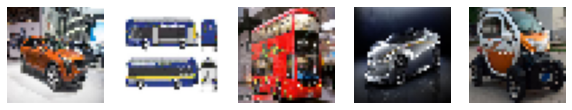

In [16]:
model.to('cpu')
model.eval()

images, targets = next(iter(trainloader))
print(images.shape, targets.shape)
fig, axes = plt.subplots(figsize=(10, 10), ncols=5)

for i in range(5):
    ax = axes[i]
    imshow(images[i], ax=ax)

In [17]:
with torch.no_grad():
    output = model.forward(images)

ps = F.softmax(output,dim=1)

In [18]:
rand_img = np.random.randint(64, size=1)[0]
rand_img

20

In [19]:
probability = ps[rand_img].data.numpy().squeeze()
probability

array([9.9982917e-01, 1.7081527e-04], dtype=float32)

<AxesSubplot:>

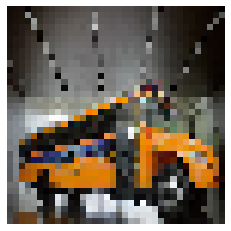

In [20]:
imshow(images[rand_img])

### <font color = 'black'>Output</font>

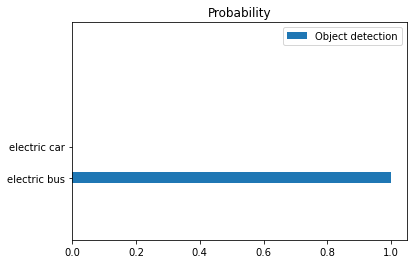

In [21]:
ind = np.arange(2)
targets = ['electric bus','electric car']
width = 0.35
locations = ind

class_probability = plt.barh(ind, probability, width, alpha=1, label = 'Object detection')

plt.yticks(np.arange(2))
plt.title('Probability')
plt.yticks(locations,targets)

#legend
plt.legend()
plt.ylim(top=5)
plt.ylim(bottom=-2)
plt.show();